In [5]:
## Standard libraries
import os
import numpy as np
import math
from PIL import Image
from functools import partial

## Imports for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
## Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
## PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip3 install pytorch-lightning>=1.4 --quiet
    import pytorch_lightning as pl
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [6]:
# Path to the folder where the datasets are be downloaded (e.g. MNIST)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/DL2/GDL"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("mps:0")
device

device(type='mps', index=0)

In [7]:
import os
import urllib.request
from urllib.error import HTTPError

# Define the path where you want to save the files (adjust this path as needed)
CHECKPOINT_PATH = "/Users/antonis/Documents/Github_Models"

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/DL2/GDL/"

# Files to download
files = ["paprika.tiff"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            # Use urllib to download files
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)


In [8]:
class GroupBase(torch.nn.Module):

    def __init__(self, dimension, identity):
        """ Implements a group.

        @param dimension: Dimensionality of the group (number of dimensions in the basis of the algebra).
        @param identity: Identity element of the group.
        """
        super().__init__()
        self.dimension = dimension
        self.register_buffer('identity', torch.Tensor(identity))

    def elements(self):
        """ Obtain a tensor containing all group elements in this group.
        
        """
        raise NotImplementedError()

    def product(self, h, h_prime):
        """ Defines group product on two group elements.

        @param h: Group element 1
        @param h_prime: Group element 2
        """
        raise NotImplementedError()

    def inverse(self, h):
        """ Defines inverse for group element.

        @param h: A group element from subgroup H.
        """
        raise NotImplementedError()

    def left_action_on_R2(self, h, x):
        """ Group action of an element from the subgroup H on a vector in R2.

        @param h: A group element from subgroup H.
        @param x: Vectors in R2.
        """
        raise NotImplementedError()

    def matrix_representation(self, h):
        """ Obtain a matrix representation in R^2 for an element h.

        @param h: Group element
        """
        raise NotImplementedError()

    def determinant(self, h):
        """ Calculate the determinant of the representation of a group element
        h.

        @param g:
        """
        raise NotImplementedError()
    
    def normalize_group_parameterization(self, h):
        """ Map the group elements to an interval [-1, 1]. We use this to create
        a standardized input for obtaining weights over the group.

        @param g:
        """
        raise NotImplementedError()

In [9]:
class CyclicGroup(GroupBase):

    def __init__(self, order):
        super().__init__(
            dimension=1,
            identity=[0.]
        )

        assert order > 1
        self.order = torch.tensor(order)

    def elements(self):
        """ Obtain a tensor containing all group elements in this group.
        
        @returns elements: Tensor containing group elements of shape [self.order]
        """
        return torch.linspace(
            start=0,
            end=2 * np.pi * float(self.order - 1) / float(self.order),
            steps=self.order,
            device=self.identity.device
        )
    
    def product(self, h, h_prime):
        """ Defines group product on two group elements of the cyclic group C4.

        @param h: Group element 1
        @param h_prime: Group element 2
        
        @returns product: Tensor containing h \cdot h_prime with \cdot the group action.
        """
        # As we directly parameterize the group by its rotation angles, this 
        # will be a simple addition. Don't forget the closure property though!

        ## YOUR CODE STARTS HERE ##
        product = torch.remainder(h + h_prime, 2 * np.pi)
        ## AND ENDS HERE ##

        return product

    def inverse(self, h):
        """ Defines group inverse for an element of the cyclic group C4.

        @param h: Group element
        
        @returns inverse: Tensor containing h^{-1}.
        """
        # Implement the inverse operation. Keep the closure property in mind!

        ## YOUR CODE STARTS HERE ##
        inverse = torch.remainder(-h, 2 * np.pi)
        ## AND ENDS HERE ##

        return inverse
    
    def left_action_on_R2(self, h, x):
        """ Group action of an element from the subgroup H on a vector in R2.

        @param h: A group element from subgroup H.
        @param x: Vectors in R2.
        
        @returns transformed_x: Tensor containing \rho(h)x.
        """
        # Transform the vector x with h, recall that we are working with a left-regular representation, 
        # meaning we transform vectors in R^2 through left-matrix multiplication.
        transformed_x = torch.tensordot(self.matrix_representation(h), x, dims=1)       
        return transformed_x

    def matrix_representation(self, h):
        """ Obtain a matrix representation in R^2 for an element h.

        @param h: A group element.
        
        @returns representation: Tensor containing matrix representation of h, shape [2, 2].
        """
        ## YOUR CODE STARTS HERE ##
        cos_t = torch.cos(h)
        sin_t = torch.sin(h)

        representation = torch.tensor([
            [cos_t, -sin_t],
            [sin_t, cos_t]
        ], device=self.identity.device)
        ## AND ENDS HERE ##

        return representation
    
    def normalize_group_elements(self, h):
        """ Normalize values of group elements to range between -1 and 1.
        The group elements range from 0 to 2pi * (self.order - 1) / self.order,
        so we normalize accordingly.

        @param h: A group element.
        @return normalized_h: Tensor containing normalized value corresponding to element h.
        """
        largest_elem = 2 * np.pi * (self.order - 1) / self.order
        normalized_h = (2*h / largest_elem) - 1.
        return normalized_h

In [10]:
# Some tests to verify our implementation.
c4 = CyclicGroup(order=4)
e, g1, g2, g3 = c4.elements()

assert c4.product(e, g1) == g1 and c4.product(g1, g2) == g3
assert c4.product(g1, c4.inverse(g1)) == e

assert torch.allclose(c4.matrix_representation(e), torch.eye(2))
assert torch.allclose(c4.matrix_representation(g2), torch.tensor([[-1, 0], [0, -1]]).float(), atol=1e-6)

assert torch.allclose(c4.left_action_on_R2(g1, torch.tensor([0., 1.])), torch.tensor([-1., 0.]), atol=1e-7)

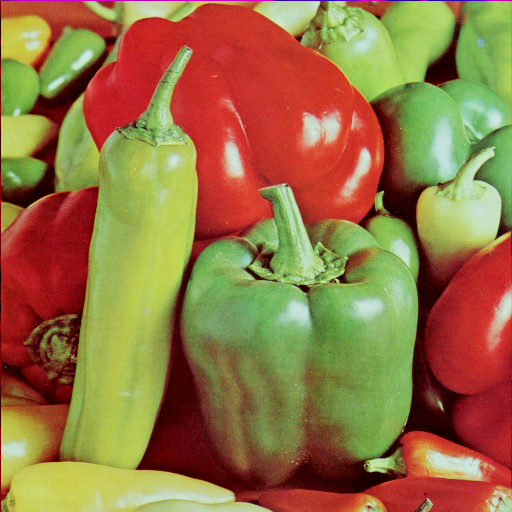

In [11]:
# Load image from disk.
img = Image.open(os.path.join(CHECKPOINT_PATH, "paprika.tiff"))

# Convert to torch tensor.
img_tensor = transforms.ToTensor()(img)
img

In [12]:
def bilinear_interpolation(signal, grid):
    """ Obtain signal values for a set of gridpoints through bilinear interpolation.
    
    @param signal: Tensor containing pixel values [C, H, W] or [N, C, H, W]
    @param grid: Tensor containing coordinate values [2, H, W] or [2, N, H, W]
    """
    # If signal or grid is a 3D array, add a dimension to support grid_sample.
    if len(signal.shape) == 3:
        signal = signal.unsqueeze(0)
    if len(grid.shape) == 3:
        grid = grid.unsqueeze(1)
    
    # Grid_sample expects [N, H, W, 2] instead of [2, N, H, W]
    grid = grid.permute(1, 2, 3, 0)
    
    # Grid sample expects YX instead of XY.
    grid = torch.roll(grid, shifts=1, dims=-1)
    
    return torch.nn.functional.grid_sample(
        signal,
        grid,
        padding_mode='zeros',
        align_corners=True,
        mode="bilinear"
    )

def trilinear_interpolation(signal, grid):
    """ 
    
    @param signal: Tensor containing pixel values [C, D, H, W] or [N, C, D, H, W]
    @param grid: Tensor containing coordinate values [3, D, H, W] or [3, N, D, H, W]
    """
    # If signal or grid is a 4D array, add a dimension to support grid_sample.
    if len(signal.shape) == 4:
        signal = signal.unsqueeze(0)
    if len(grid.shape) == 4:
        grid = grid.unsqueeze(1)

    # Grid_sample expects [N, D, H, W, 3] instead of [3, N, D, H, W]
    grid = grid.permute(1, 2, 3, 4, 0)
    
    # Grid sample expects YX instead of XY.
    grid = torch.roll(grid, shifts=1, dims=-1)
    
    return torch.nn.functional.grid_sample(
        signal, 
        grid,
        padding_mode='zeros',
        align_corners=True,
        mode="bilinear" # actually trilinear in this case...
    )

In [14]:
# This creates a grid of the pixel locations in our image of [2, 512, 512] since 
# our image is 2 dimensional and has a width and height of 512 pixels.
img_grid = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, img_tensor.shape[-2]),
    torch.linspace(-1, 1, img_tensor.shape[-1]),
    indexing='ij'
))

# Let's create the group of 90 degree clockwise rotations.
c4 = CyclicGroup(order=4)
e, g1, g2, _ = c4.elements()

# Create a counterclockwise rotation of 270 degrees using only e, g1 and g2.

## YOUR CODE STARTS HERE ##
g3 = c4.product(g1, g2)
## AND ENDS HERE ##

assert g3 == c4.elements()[-1]

In [15]:
# Transform the image grid we just created with the matrix representation of 
# this group element.
transformed_img_grid = c4.left_action_on_R2(c4.inverse(g3), img_grid)

# Sample the image on the transformed grid points.
transformed_img = bilinear_interpolation(img_tensor, transformed_img_grid)[0]

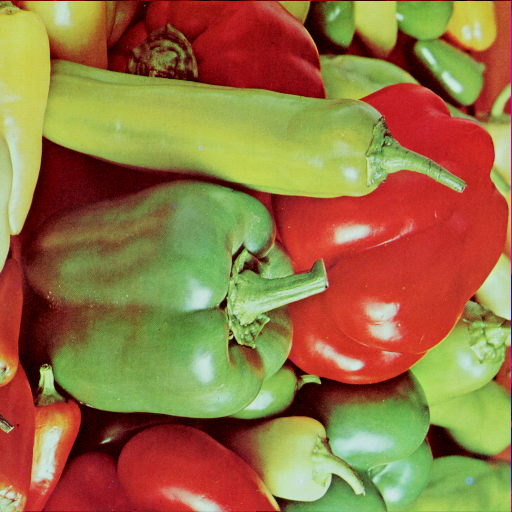

In [16]:
# If we turn this back into a PIL image we can see the result of our transformation!
transforms.ToPILImage()(transformed_img)

In implementing the actual lifting and group convolution operations, we will make use of PyTorch's Conv2D class. This simplifies our life a lot, since Conv2D takes cares of translating the kernels  𝑘  over all input locations. Hence we do not need to implement the action of the translation group ourselves ( 𝐱 ), but will still remain translation equivariant! Making our operations compatible with Conv2D requires a small amount of trickery, but we will get to that later.

In [17]:
class LiftingKernelBase(torch.nn.Module):
    
    def __init__(self, group, kernel_size, in_channels, out_channels):
        """ Implements a base class for the lifting kernel. Stores the R^2 grid
        over which the lifting kernel is defined and it's transformed copies
        under the action of a group H.
        
        """
        super().__init__()
        self.group = group

        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Create spatial kernel grid. These are the coordinates on which our
        # kernel weights are defined.
        self.register_buffer("grid_R2", torch.stack(torch.meshgrid(
            torch.linspace(-1., 1., self.kernel_size),
            torch.linspace(-1., 1., self.kernel_size),
            indexing='ij'
        )).to(self.group.identity.device))

        # Transform the grid by the elements in this group.
        self.register_buffer("transformed_grid_R2", self.create_transformed_grid_R2())

    def create_transformed_grid_R2(self):
        """Transform the created grid by the group action of each group element.
        This yields a grid (over H) of spatial grids (over R2). In other words,
        a list of grids, each index of which is the original spatial grid transformed by
        a corresponding group element in H.
        
        """
        # Obtain all group elements.

        ## YOUR CODE STARTS HERE ##
        group_elements = self.group.elements()
        ## AND ENDS HERE ##

        # Transform the grid defined over R2 with the sampled group elements.
        # Recall how the left-regular representation acts on the domain of a 
        # function on R2! (Hint: look closely at the equation given under 1.3)
        # We'd like to end up with a grid of shape [2, |H|, kernel_size, kernel_size].

        ## YOUR CODE STARTS HERE ##
        transformed_grids = []
        for element in self.group.inverse(group_elements):
            transformed_grids.append(
                self.group.left_action_on_R2(element, self.grid_R2)
            )
        transformed_grid = torch.stack(transformed_grids, dim=1)
        ## AND ENDS HERE ##

        return transformed_grid


    def sample(self, sampled_group_elements):
        """ Sample convolution kernels for a given number of group elements

        arguments should include:
        :param sampled_group_elements: the group elements over which to sample
            the convolution kernels

        should return:
        :return kernels: filter bank extending over all input channels, 
            containing kernels transformed for all output group elements.
        """
        raise NotImplementedError()


In [18]:
# Let's check whether our implementation works correctly. First we inspect the
# shape of our transformed grids to assess whether this is correct.
order = 4
lifting_kernel_base = LiftingKernelBase(
    group=CyclicGroup(order=order),
    kernel_size=7,
    in_channels=3,
    out_channels=1
)

# The grid has a shape of [2, |H|, kernel_size, kernel_size].
assert lifting_kernel_base.transformed_grid_R2.shape == torch.Size([2, 4, 7, 7])

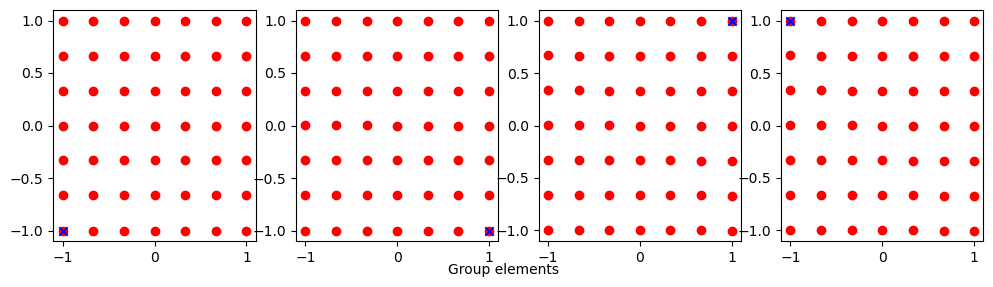

In [19]:
plt.rcParams['figure.figsize'] = [12, 3]

# Create [group_elements] figures
fig, ax = plt.subplots(1, order)

# Get the grid
transformed_grid_R2 = lifting_kernel_base.transformed_grid_R2

# Visualize the transformed kernel grids. We mark the same cornerpoint by a 
# blue 'x' in all grids as reference point.
for group_elem in range(order):
    ax[group_elem].scatter(
        transformed_grid_R2[1, group_elem, :, :],
        transformed_grid_R2[0, group_elem, :, :],
        c='r'
    )
    # Mark a corner point so we can see it transform.
    ax[group_elem].scatter(
        transformed_grid_R2[1, group_elem, 0, 0],
        transformed_grid_R2[0, group_elem, 0, 0],
        marker='x',
        c='b'
    )

fig.text(0.5, 0., 'Group elements', ha='center')
plt.show()

In [23]:
class InterpolativeLiftingKernel(LiftingKernelBase):

    def __init__(self, group, kernel_size, in_channels, out_channels):
        super().__init__(group, kernel_size, in_channels, out_channels)

        # Create and initialise a set of weights, we will interpolate these
        # to create our transformed spatial kernels.
        self.weight = torch.nn.Parameter(torch.zeros((
            self.out_channels,
            self.in_channels,
            self.kernel_size,
            self.kernel_size
        ), device=self.group.identity.device))

        # Initialize weights using kaiming uniform intialisation.
        torch.nn.init.kaiming_uniform_(self.weight.data, a=math.sqrt(5))
    
    def sample(self):
        """ Sample convolution kernels for a given number of group elements

        should return:
        :return kernels: filter bank extending over all input channels, 
            containing kernels transformed for all output group elements.
        """
        # First, we fold the output channel dim into the input channel dim; 
        # this allows us to transform the entire filter bank in one go using the
        # torch grid_sample function.

        ## YOUR CODE STARTS HERE ##
        weight = self.weight.view(
            self.out_channels * self.in_channels,
            self.kernel_size,
            self.kernel_size
        )
        ## AND ENDS HERE ##

        # Sample the transformed kernels.
        transformed_weight = []
        for spatial_grid_idx in range(self.group.elements().numel()):
            transformed_weight.append(
                bilinear_interpolation(weight, self.transformed_grid_R2[:, spatial_grid_idx, :, :])
            )
        transformed_weight = torch.stack(transformed_weight)
            
        # Separate input and output channels.
        transformed_weight = transformed_weight.view(
            self.group.elements().numel(),
            self.out_channels,
            self.in_channels,
            self.kernel_size,
            self.kernel_size
        )
        
        # Put out channel dimension before group dimension. We do this
        # to be able to use pytorched Conv2D. Details below!
        transformed_weight = transformed_weight.transpose(0, 1)

        return transformed_weight

In [24]:
ik = InterpolativeLiftingKernel(
    group=CyclicGroup(order=4),
    kernel_size=7,
    in_channels=2,
    out_channels=1
)

weights = ik.sample()
weights.shape

torch.Size([1, 4, 2, 7, 7])

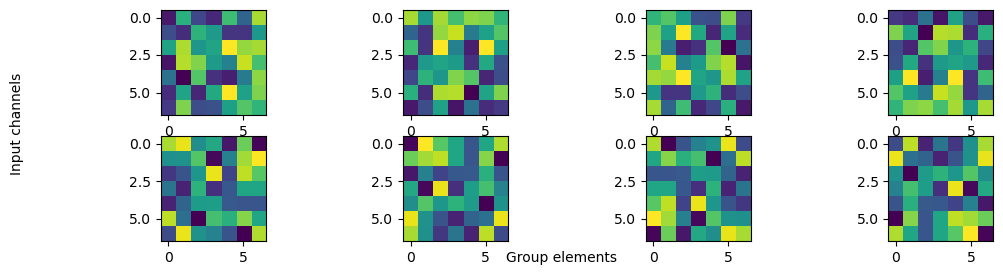

In [25]:
# Pick an output channel to visualize
out_channel_idx = 0

# Create [in_channels, group_elements] figures
fig, ax = plt.subplots(ik.in_channels, ik.group.elements().numel())

for in_channel in range(ik.in_channels):
    for group_elem in range(ik.group.elements().numel()):
        ax[in_channel, group_elem].imshow(
            weights[out_channel_idx, group_elem, in_channel, :, :].detach().numpy()
        )

fig.text(0.5, 0.04, 'Group elements', ha='center')
fig.text(0.04, 0.5, 'Input channels', va='center', rotation='vertical')

plt.show()